# Prescriptive-Analytics-Project2-Beijing-Air-Quality-Data-Set

## Machine Learning and Data Mining project, in this project we would try to predict air pollution in Beijing, China, using the data set "Beijing Multi-Site Air-Quality Data Data Set"

## Autores: Marco Quichimbo e Isaac Reyes

### Task 1: Data import, cleanup, and preprocessing


Focus should be on importing the data provided in a suitable format so that subsequent analysis is more easy. Also verify if it is necessary to perform any data cleaning and/or preprocessing steps.



In [6]:
#libraries
import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import missingno as msno # null data 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
 




In [7]:
#load Aotizhongxin and Changping data to join in a dataframe
df_Aotizhongxin = pd.read_csv(filepath_or_buffer = os.path.join('../Data/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv'))
df_Changping = pd.read_csv(filepath_or_buffer = os.path.join('../Data/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv'))
df = pd.concat([df_Aotizhongxin, df_Changping], ignore_index=True)

In [8]:
#data preview
df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,35060,2017,2,28,19,28.0,47.0,4.0,14.0,300.0,NaN,11.7,1008.9,-13.3,0.0,NNE,1.3,Changping
70124,35061,2017,2,28,20,12.0,12.0,3.0,23.0,500.0,64.0,10.9,1009.0,-14.0,0.0,N,2.1,Changping
70125,35062,2017,2,28,21,7.0,23.0,5.0,17.0,500.0,68.0,9.5,1009.4,-13.0,0.0,N,1.5,Changping
70126,35063,2017,2,28,22,11.0,20.0,3.0,15.0,500.0,72.0,7.8,1009.6,-12.6,0.0,NW,1.4,Changping


### Identify possible variables  to be deleted
No = Row number, don't apport any relevant information \
Station = Name of the air-quality monitoring site, don't apport relevant information

In [9]:
#drop variables
variables_to_delete = ['No']
df = df.drop(variables_to_delete,axis = 1)

Add the new categorical AQI variable 

In [10]:
# Funcion para calcular el AQI
def calculate_aqi_category(row):
    pollutants = {
        'PM2.5': [(0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 350.4, 301, 400), (350.5, 500.4, 401, 500)],
        'PM10': [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150), (255, 354, 151, 200), (355, 424, 201, 300), (425, 504, 301, 400), (505, 604, 401, 500)],
        'SO2': [(0, 35, 0, 50), (36, 75, 51, 100), (76, 185, 101, 150), (186, 304, 151, 200), (305, 604, 201, 300), (605, 804, 301, 400), (805, 1004, 401, 500)],
        'NO2': [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), (361, 649, 151, 200), (650, 1249, 201, 300), (1250, 1649, 301, 400), (1650, 2049, 401, 500)],
        'CO': [(0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200), (15.5, 30.4, 201, 300), (30.5, 40.4, 301, 400), (40.5, 50.4, 401, 500)],
        'O3': [(0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150), (86, 105, 151, 200), (106, 200, 201, 300), (201, 404, 301, 400), (405, 504, 401, 500), (505, 604, 501, 600)]
    }
    
    aqi = 0
    for pollutant, ranges in pollutants.items():
        concentration = row[pollutant]
        for r in ranges:
            if r[0] <= concentration <= r[1]:
                B_low, B_high, I_low, I_high = r
                aqi = max(aqi, ((I_high - I_low) / (B_high - B_low)) * (concentration - B_low) + I_low)
                break
                
    if aqi <= 100:
        return 'Excellent - Good'
    elif aqi <= 200:
        return 'Slightly - Lightly Polluted'
    elif aqi <= 300:
        return 'Moderately - Heavily Polluted'
    else:
        return 'Severely Polluted'

    
df['AQI'] = df.apply(calculate_aqi_category, axis=1)

### Cleaning process

In [11]:
# A brief summary of the data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,70128.0,2014.662560,1.177205,2013.0000,2014.00,2015.0,2016.00,2017.0
month,70128.0,6.522930,3.448728,1.0000,4.00,7.0,10.00,12.0
day,70128.0,15.729637,8.800155,1.0000,8.00,16.0,23.00,31.0
hour,70128.0,11.500000,6.922236,0.0000,5.75,11.5,17.25,23.0
PM2.5,68429.0,76.923797,77.595355,2.0000,20.00,52.0,107.00,898.0
PM10,68828.0,102.343914,89.844789,2.0000,35.00,79.0,143.00,999.0
SO2,68565.0,16.161992,21.947656,0.2856,3.00,8.0,20.00,341.0
NO2,68438.0,51.704624,34.356419,1.8477,25.00,44.0,71.00,290.0
CO,66831.0,1207.412159,1164.832643,100.0000,500.00,800.0,1500.00,10000.0
O3,67805.0,57.159726,56.120958,0.2142,11.00,45.0,81.00,429.0


RAIN variable looks strange, there is no variability \
We could delete this one

In [12]:
unique_rain = df['RAIN'].value_counts()
unique_rain

0.0     67327
0.1       601
0.2       307
0.3       229
0.5       152
        ...  
13.8        1
10.6        1
17.9        1
72.5        1
5.8         1
Name: RAIN, Length: 163, dtype: int64

In [13]:
#delete rain variable
df = df.drop(['RAIN'], axis = 1)

Dependences between variables

C:\Users\Marcos\AppData\Local\Temp\ipykernel_15920\2701088972.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=0.7,annot=True,cmap='GnBu')


<Axes: title={'center': 'Pearson'}>

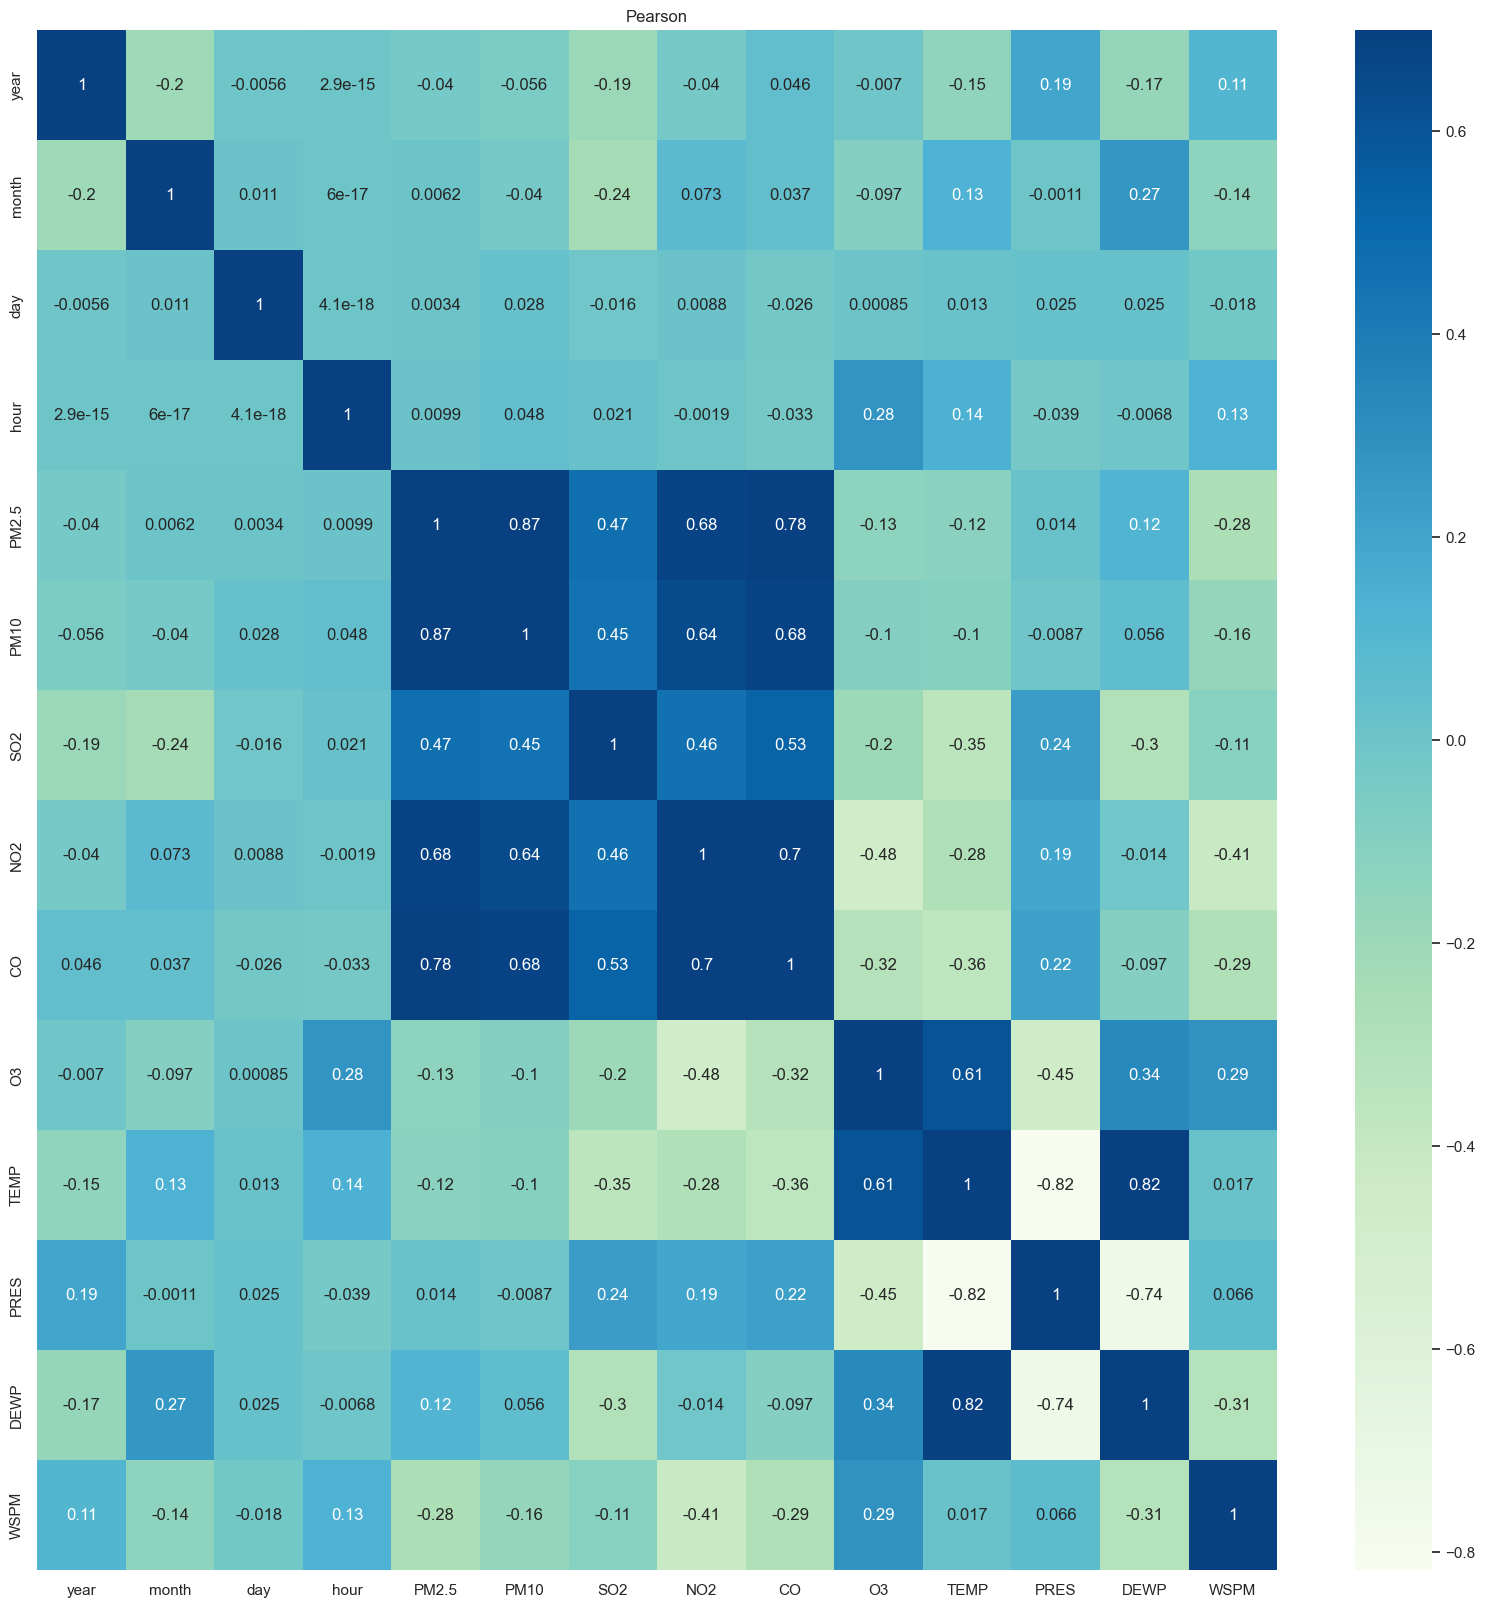

In [14]:
#Person to identify variables dependences
sns.set(style='whitegrid',font_scale=1)
plt.figure(figsize=(20,20))
plt.title('Pearson')
sns.heatmap(df.corr(),vmax=0.7,annot=True,cmap='GnBu')

We apreciate a strong relation between PM10 & PM2.5\
Conserve PM10 because it's one of the five parameters to *AQI*, and delete the other one /
Also the strong relation between TEMP & DEWP /
Delete Dewp

In [15]:
#delete PM2.5
df = df.drop(['PM2.5'], axis=1)
df = df.drop(['DEWP'], axis=1)

C:\Users\Marcos\AppData\Local\Temp\ipykernel_15920\2701088972.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=0.7,annot=True,cmap='GnBu')


<Axes: title={'center': 'Pearson'}>

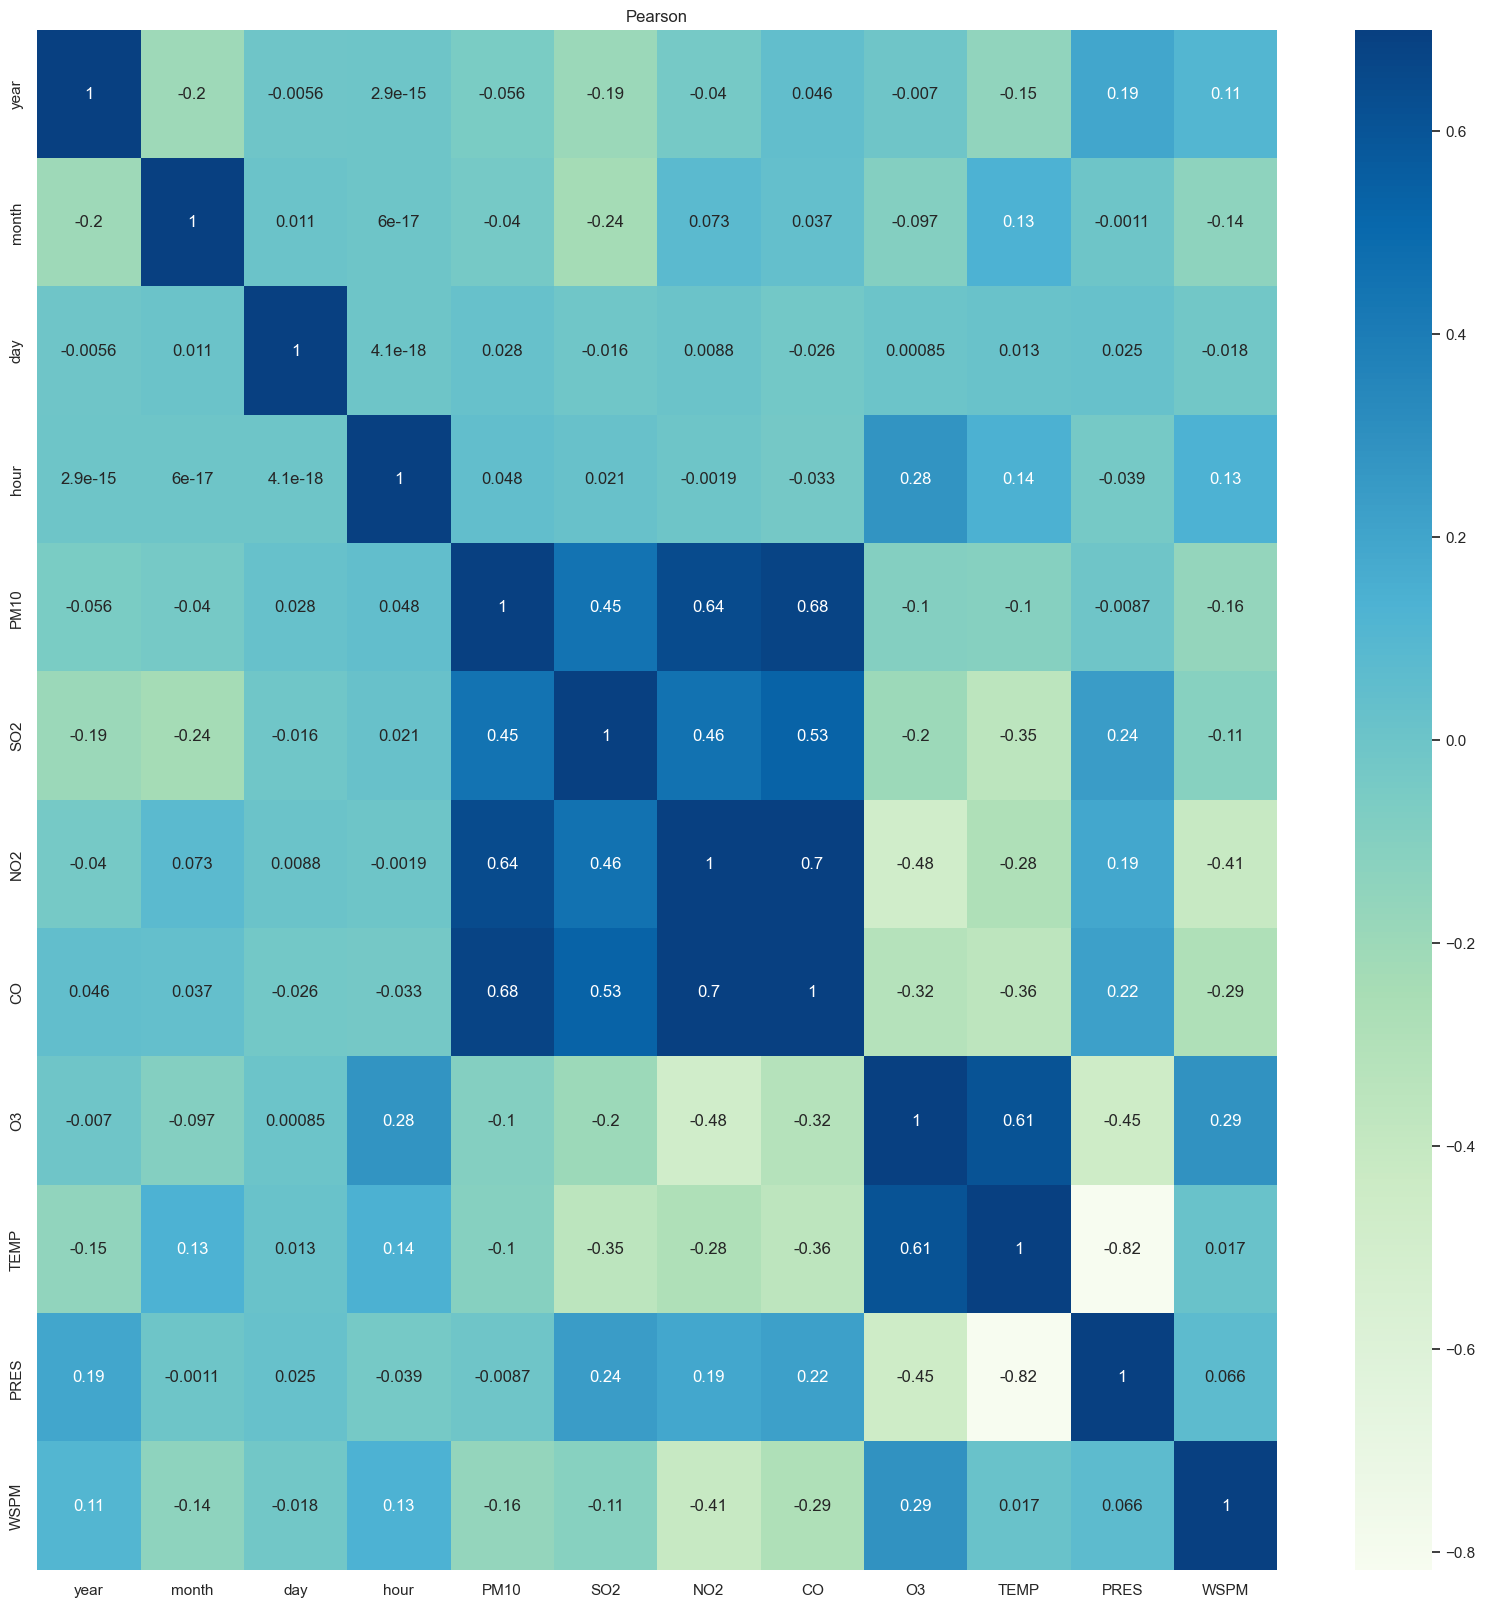

In [16]:
#Person to identify variables dependences
sns.set(style='whitegrid',font_scale=1)
plt.figure(figsize=(20,20))
plt.title('Pearson')
sns.heatmap(df.corr(),vmax=0.7,annot=True,cmap='GnBu')

### Work around null values

In [17]:
# what kind of datatype I'm working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     70128 non-null  int64  
 1   month    70128 non-null  int64  
 2   day      70128 non-null  int64  
 3   hour     70128 non-null  int64  
 4   PM10     68828 non-null  float64
 5   SO2      68565 non-null  float64
 6   NO2      68438 non-null  float64
 7   CO       66831 non-null  float64
 8   O3       67805 non-null  float64
 9   TEMP     70055 non-null  float64
 10  PRES     70058 non-null  float64
 11  wd       69907 non-null  object 
 12  WSPM     70071 non-null  float64
 13  station  70128 non-null  object 
 14  AQI      70128 non-null  object 
dtypes: float64(8), int64(4), object(3)
memory usage: 8.0+ MB


We have a categorical variable with null values \
The other ones are numeric values

In [18]:
#identify null values
df.isnull().sum()

year          0
month         0
day           0
hour          0
PM10       1300
SO2        1563
NO2        1690
CO         3297
O3         2323
TEMP         73
PRES         70
wd          221
WSPM         57
station       0
AQI           0
dtype: int64

### wd
null values in the categorical variable are 221, it's means we could delete the null values, it is a very small portion of the data set

In [19]:
#delele categoriacal wd registers
df = df.dropna(subset=['wd'])

In [20]:
#apply dummies - one-hot encoding
df = pd.get_dummies(df, columns = ['wd'])
df.head()

,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,...,1,0,0,0,0,0,0,0,0,0
1,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,...,0,0,0,0,0,0,0,0,0,0
2,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,...,1,0,0,0,0,0,0,0,0,0
3,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,...,0,1,0,0,0,0,0,0,0,0
4,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#numeric nulls 
df.isnull().sum()

year          0
month         0
day           0
hour          0
PM10       1298
SO2        1562
NO2        1689
CO         3294
O3         2317
TEMP         16
PRES         13
WSPM          0
station       0
AQI           0
wd_E          0
wd_ENE        0
wd_ESE        0
wd_N          0
wd_NE         0
wd_NNE        0
wd_NNW        0
wd_NW         0
wd_S          0
wd_SE         0
wd_SSE        0
wd_SSW        0
wd_SW         0
wd_W          0
wd_WNW        0
wd_WSW        0
dtype: int64

As you can appreciate, the numeric null values are less than 30% of the data, so we can imput, null values

In [22]:
#we imput whit the mean
column_to_imput = ['PM10','SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES']

for columna in column_to_imput:
    media = df[columna].mean()
    df[columna] = df[columna].fillna(media)


In [23]:
#just to confirm, there's no null values
df.isnull().sum()

year       0
month      0
day        0
hour       0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
WSPM       0
station    0
AQI        0
wd_E       0
wd_ENE     0
wd_ESE     0
wd_N       0
wd_NE      0
wd_NNE     0
wd_NNW     0
wd_NW      0
wd_S       0
wd_SE      0
wd_SSE     0
wd_SSW     0
wd_SW      0
wd_W       0
wd_WNW     0
wd_WSW     0
dtype: int64

<Axes: >

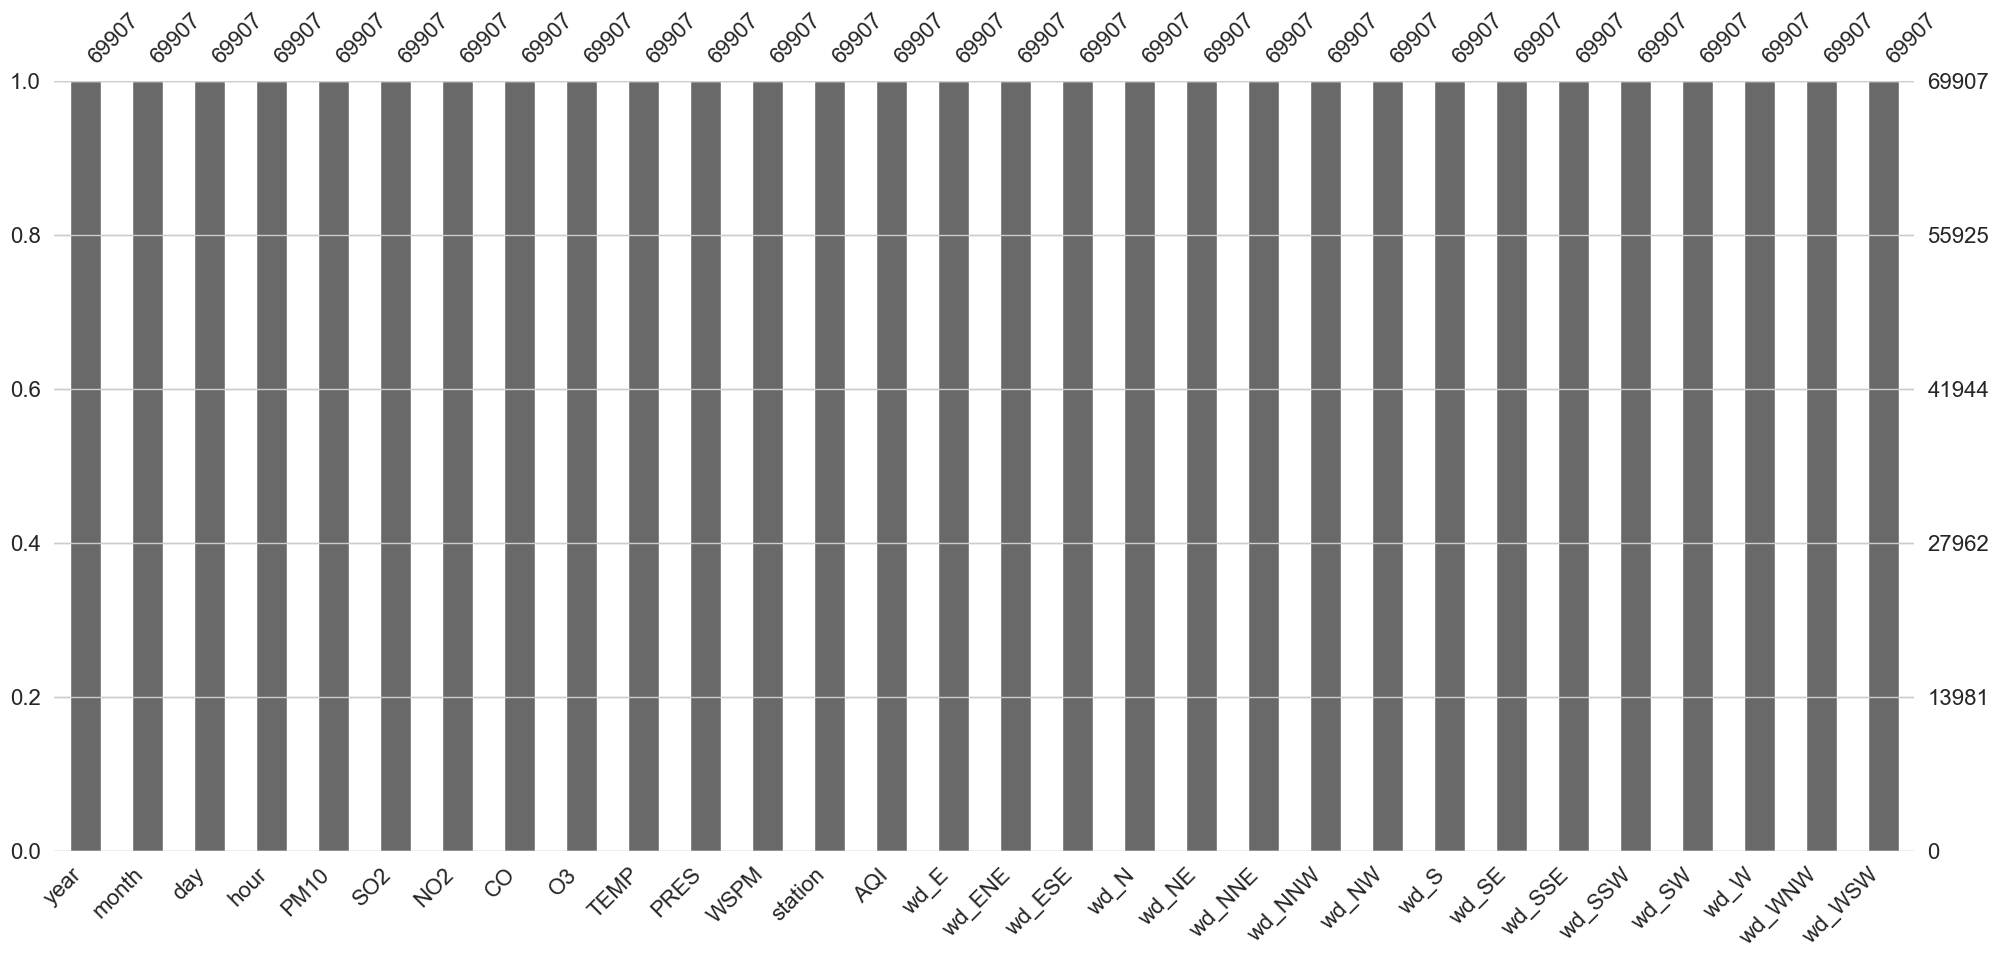

In [24]:
msno.bar(df)

General view of how the data is distributed

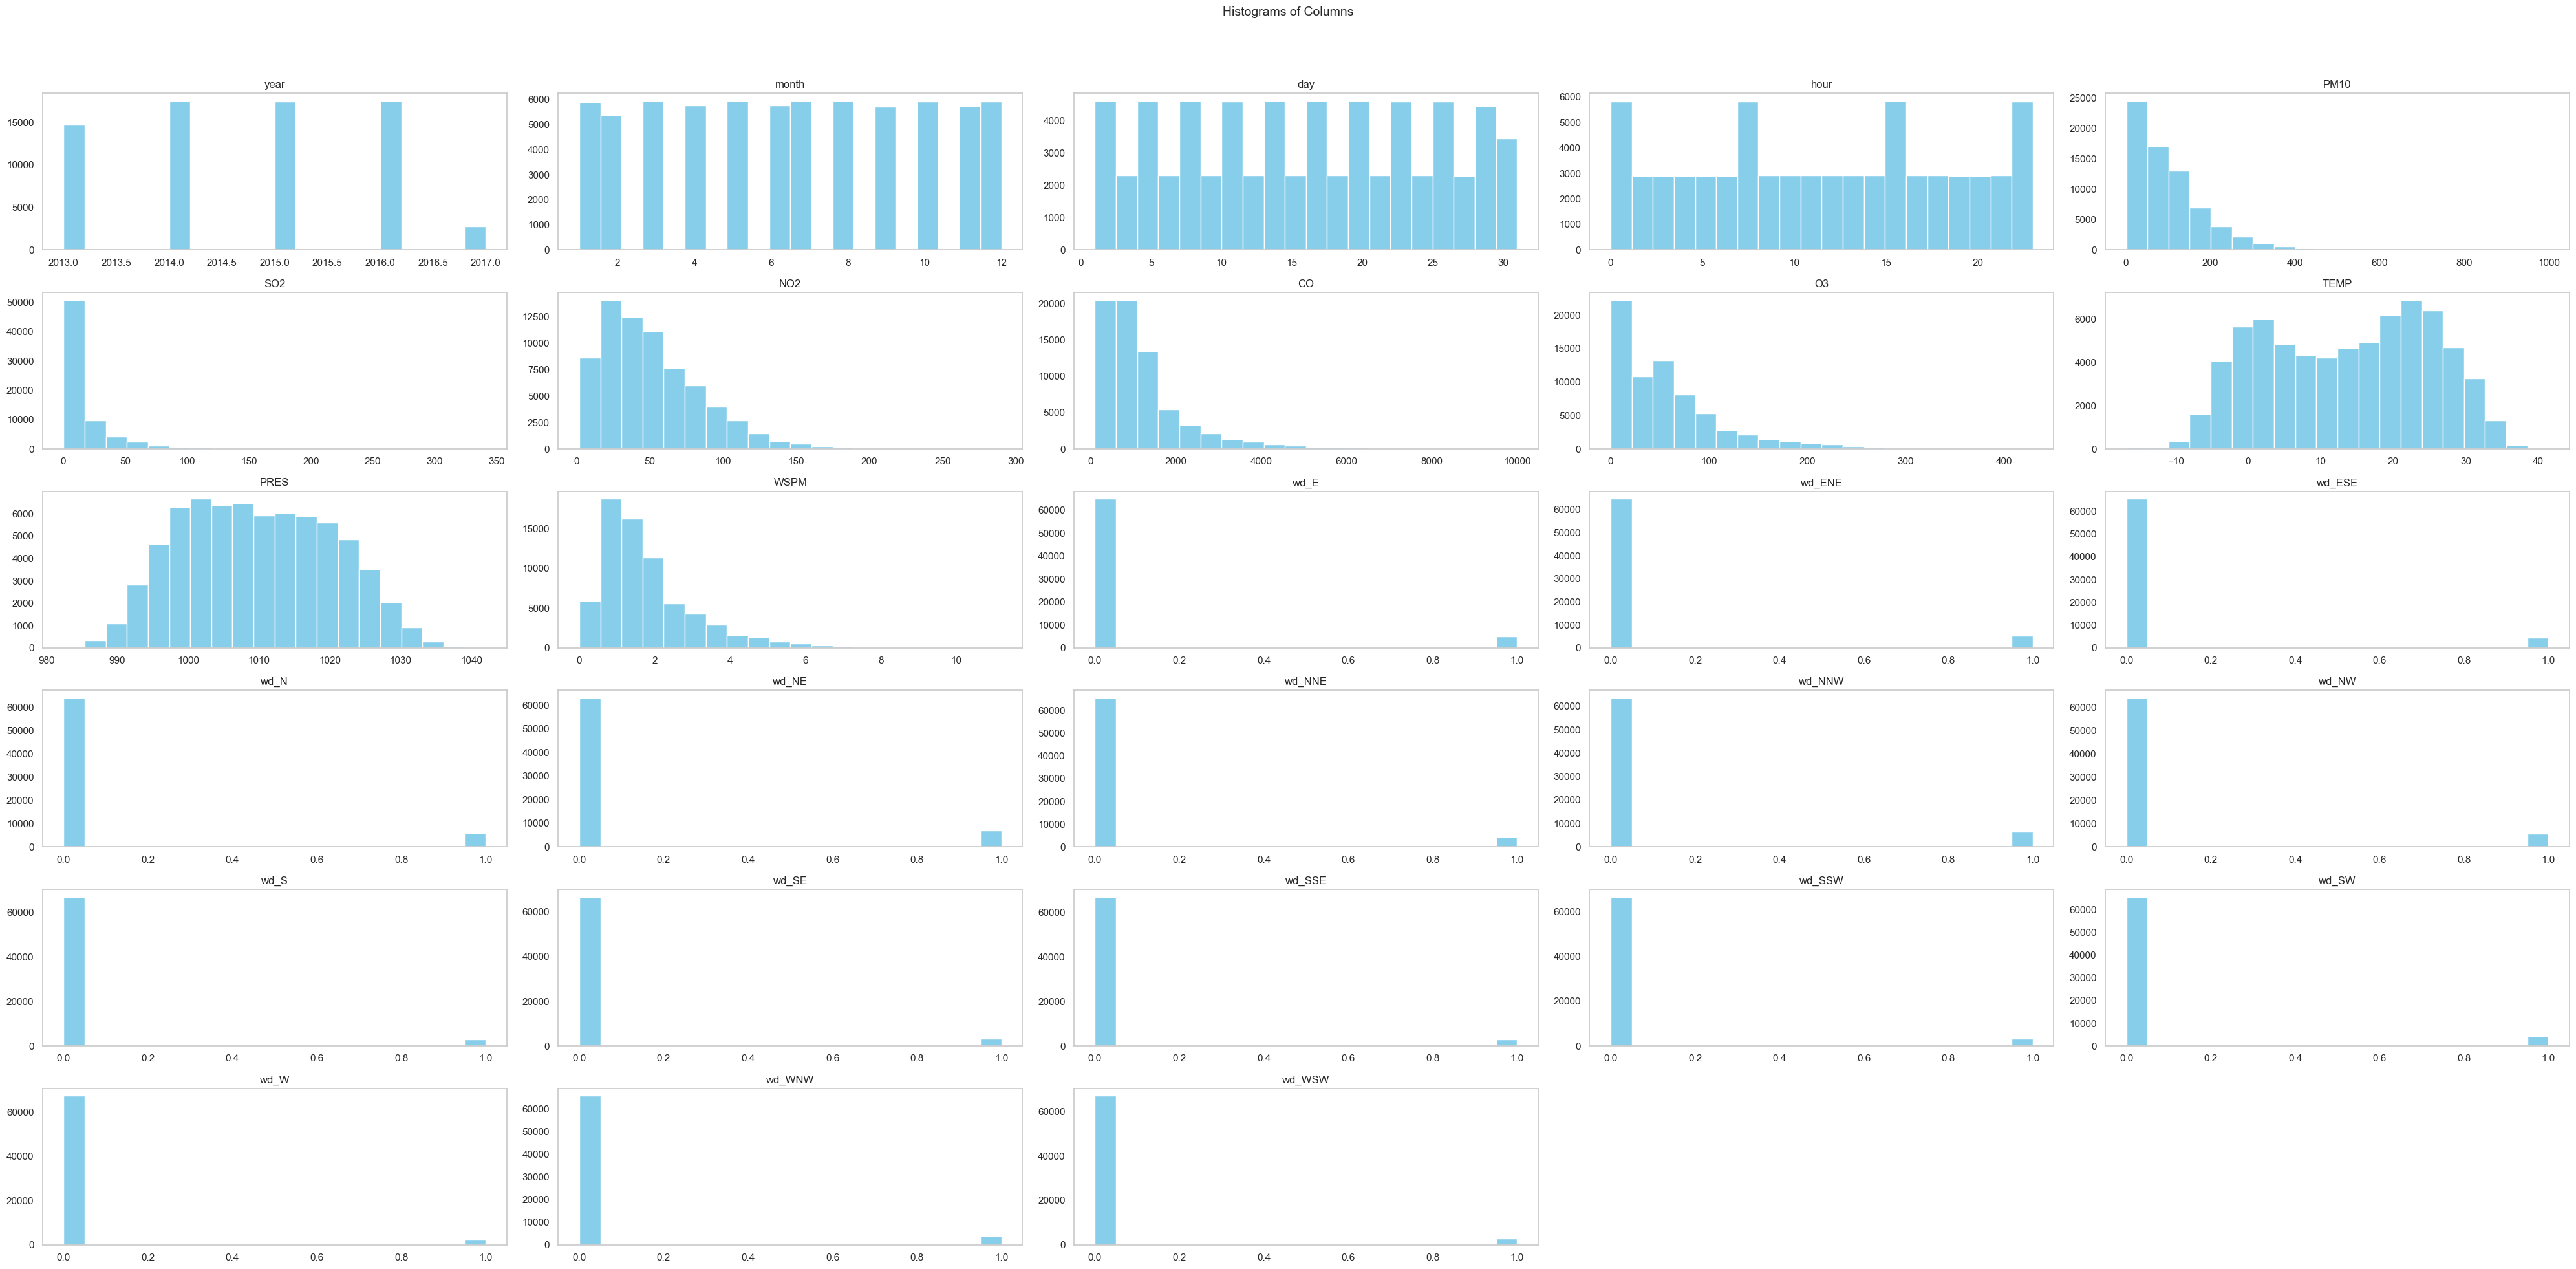

In [25]:
#general view of the data
df.hist(bins=20, figsize=(40, 20), grid=False, color='skyblue')
plt.suptitle('Histograms of Columns', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Working around the two object variables

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69907 entries, 0 to 70127
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     69907 non-null  int64  
 1   month    69907 non-null  int64  
 2   day      69907 non-null  int64  
 3   hour     69907 non-null  int64  
 4   PM10     69907 non-null  float64
 5   SO2      69907 non-null  float64
 6   NO2      69907 non-null  float64
 7   CO       69907 non-null  float64
 8   O3       69907 non-null  float64
 9   TEMP     69907 non-null  float64
 10  PRES     69907 non-null  float64
 11  WSPM     69907 non-null  float64
 12  station  69907 non-null  object 
 13  AQI      69907 non-null  object 
 14  wd_E     69907 non-null  uint8  
 15  wd_ENE   69907 non-null  uint8  
 16  wd_ESE   69907 non-null  uint8  
 17  wd_N     69907 non-null  uint8  
 18  wd_NE    69907 non-null  uint8  
 19  wd_NNE   69907 non-null  uint8  
 20  wd_NNW   69907 non-null  uint8  
 21  wd_NW    699

In [27]:
#apply label encoder to transform to categorical to numerics variables 
le = LabelEncoder()
df['station'] = le.fit_transform(df['station'])
df['AQI'] = le.fit_transform(df['AQI'])

At this point all the variables are numeric 

### Working around numerical outliers values



ValueError: num must be an integer with 1 <= num <= 9, not 10

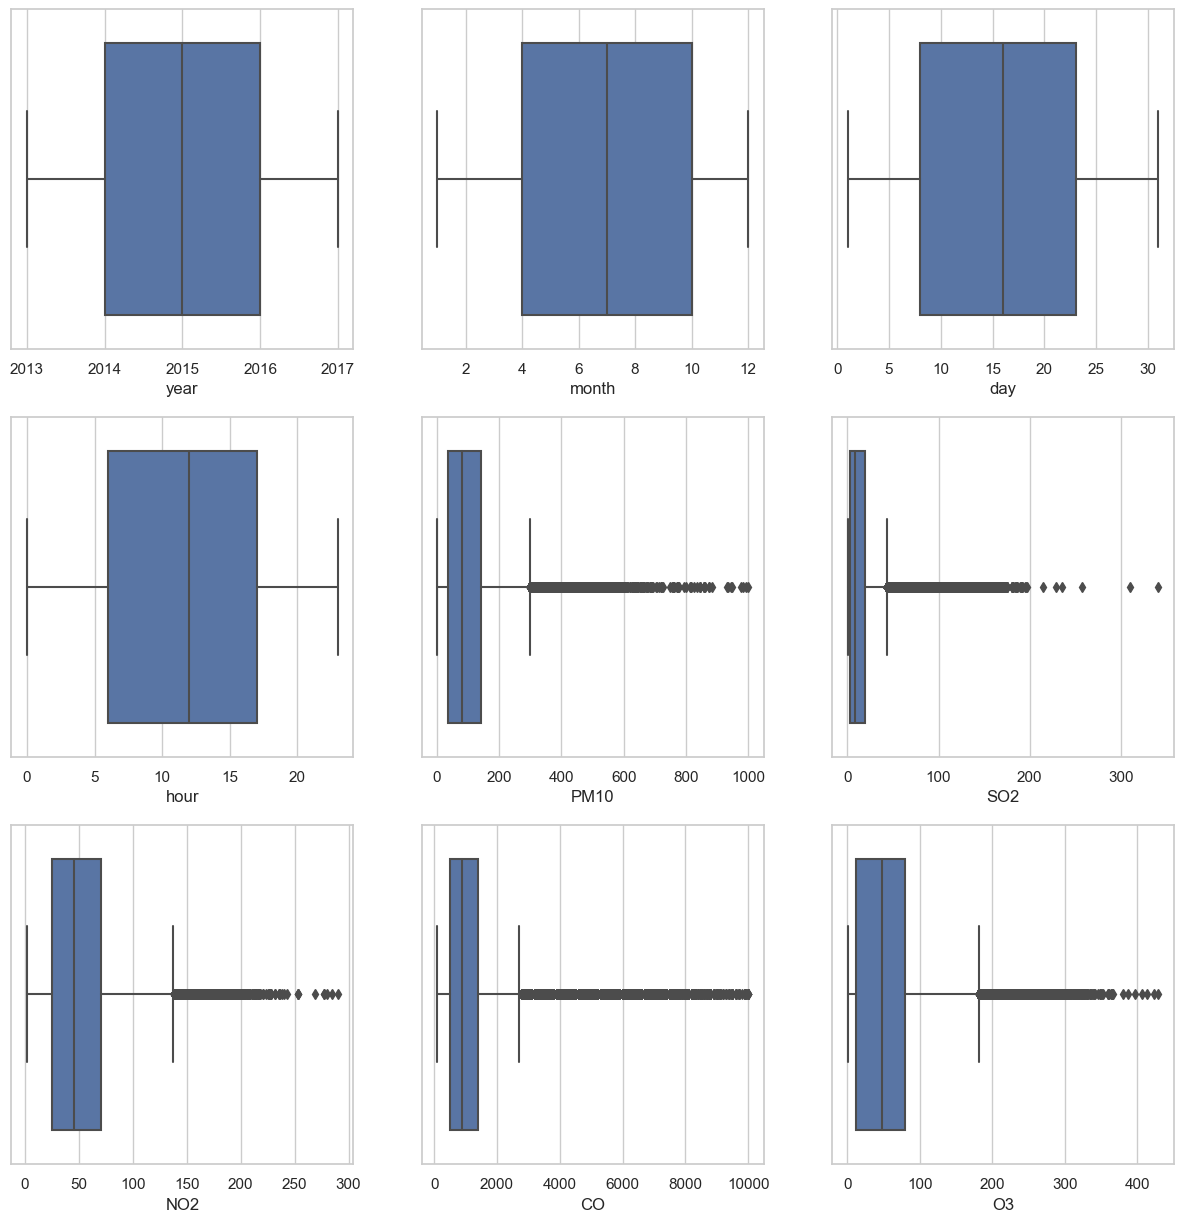

In [28]:
# box plot 
plt.figure(figsize=(15,15))
f=df.columns[:-1]
for i in enumerate(f):
  plt.subplot(3,3,i[0]+1)
  sns.boxplot(x=i[1],data=df)

In [ ]:
#cut off 10% of tails
numeric_variables = df.select_dtypes(include=[np.number]).columns

for i in numeric_variables:
  q1 = df[i].quantile(0.1)
  q4 = df[i].quantile(0.9)
  df[i][df[i]<=q1] =q1
  df[i][df[i]>=q4] =q4

C:\Users\Marcos\AppData\Local\Temp\ipykernel_9096\1919211514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]<=q1] =q1
C:\Users\Marcos\AppData\Local\Temp\ipykernel_9096\1919211514.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]>=q4] =q4
C:\Users\Marcos\AppData\Local\Temp\ipykernel_9096\1919211514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]<=q1] =q1
C:\Users\Marcos\AppData\Local\Temp\ip

ValueError: num must be an integer with 1 <= num <= 9, not 10

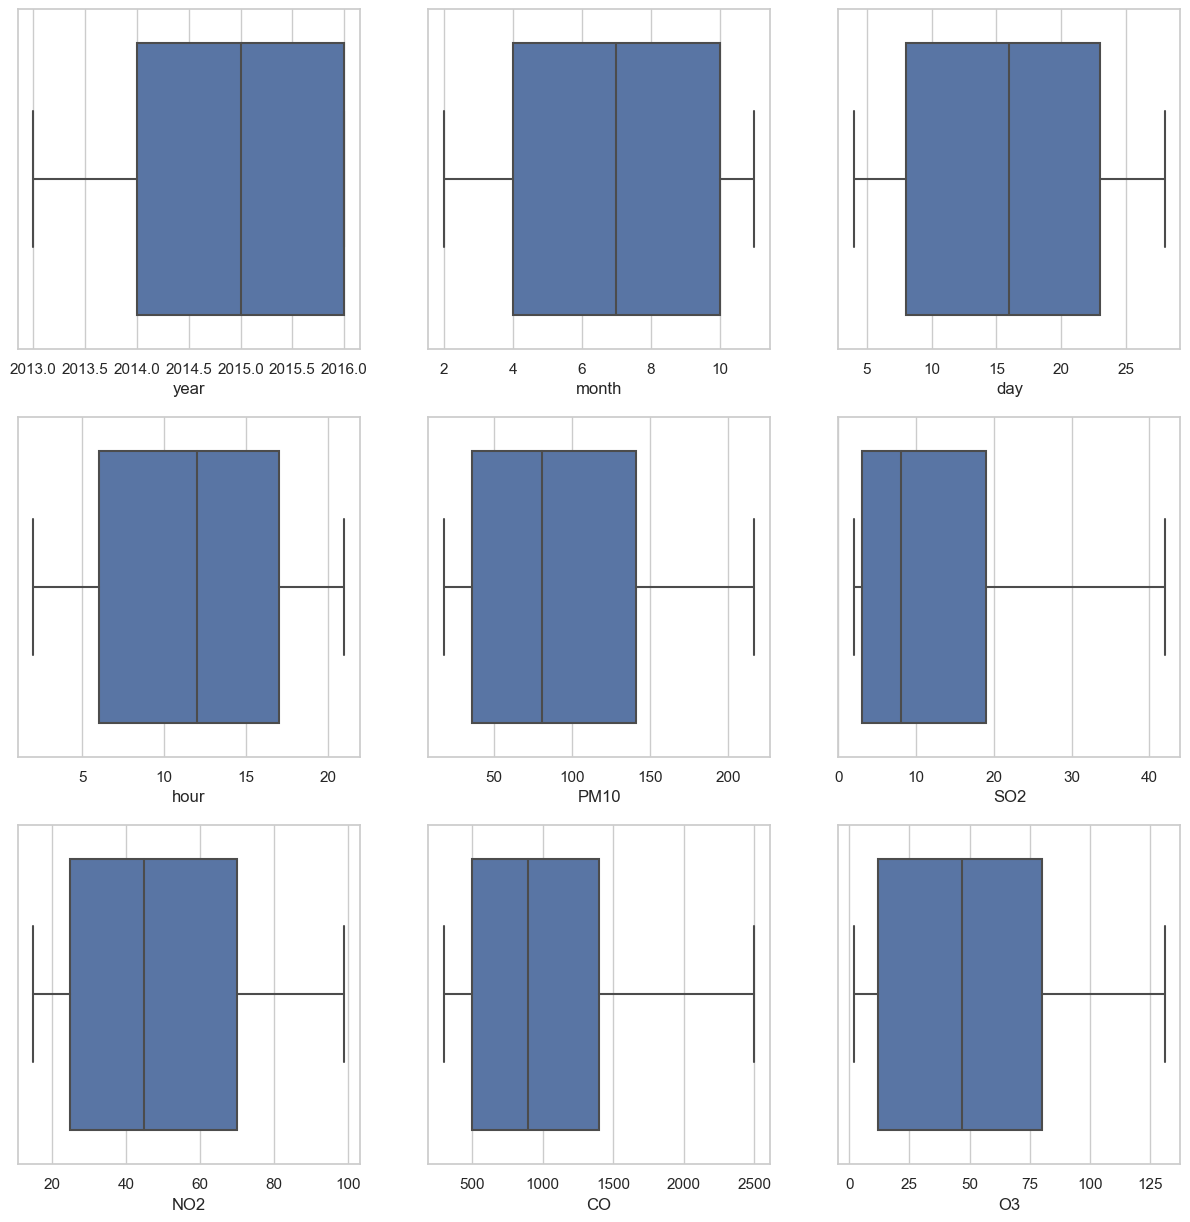

In [ ]:
# box plot again to check the results 
plt.figure(figsize=(15,15))
f=df.columns[:-1]
for i in enumerate(f):
  plt.subplot(3,3,i[0]+1)
  sns.boxplot(x=i[1],data=df)

### Data Balancing 

In [29]:
#count each class in AQI
df['AQI'].value_counts()

3    31166
0    19371
1    14388
2     4982
Name: AQI, dtype: int64

In [30]:
#split X variales and Y predict 
X = df.drop('AQI', axis=1)
y = df['AQI']

#over sample to equal data balancing 
ros = RandomOverSampler()
X, y = ros.fit_resample(X,y)
y.value_counts()

3    31166
0    31166
1    31166
2    31166
Name: AQI, dtype: int64

In [31]:
df_balanced = pd.concat([pd.DataFrame(X, columns=X.columns), pd.DataFrame(y, columns=['AQI'])], axis=1)
class_counts = df_balanced['AQI'].value_counts()
df = df_balanced
print(class_counts)

3    31166
0    31166
1    31166
2    31166
Name: AQI, dtype: int64


### Training and testing 

In [32]:
#split the data X & y
X = df.drop('AQI', axis=1)
y = df['AQI']

In [33]:
#scaler, to set the data in specific ranges 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [34]:
#split the data, train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)

### SVC

In [35]:
#we use support vector classifier 21 minutes to compile 
from sklearn.svm import SVC 
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [36]:
#evaluation metrics 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.832620320855615
Precision: 0.832620320855615
Recall: 0.832620320855615
F1 Score: 0.8326203208556151


In [ ]:
#cross validation 
scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("average accuracy:", scores.mean())

Save the model 

In [37]:
import joblib

# Save the trained model
joblib.dump(model, 'svc_model.joblib')


['svc_model.joblib']

In [38]:
import joblib

# Load the saved model
loaded_model = joblib.load('svc_model.joblib')


In [ ]:
#model ready to use 
X_new = preprocess(new_data)  # Preprocess the new data

# Use the loaded model to make predictions on the new data
y_pred_new = loaded_model.predict(X_new)
